帧数： 16000
声道数： 1
帧速率： 16000
实例的比特宽度，即每一帧的字节数 2


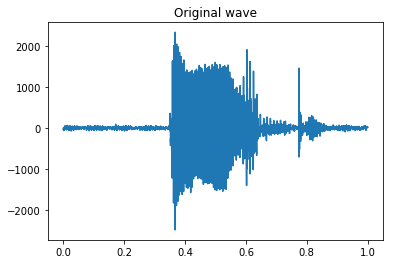

[ 0.51364299  0.51301812  0.51301812 ...,  0.51801708  0.51739221
  0.51864195]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1600)              25601600  
_________________________________________________________________
dense_6 (Dense)              (None, 160)               256160    
_________________________________________________________________
dense_7 (Dense)              (None, 1600)              257600    
_________________________________________________________________
dense_8 (Dense)              (None, 16000)             25616000  
Total params: 51,731,360
Trainable params: 51,731,360
Non-trainable params: 0
_________________________________________________________________


C:\Users\86158\Anaconda3\lib\site-packages\ipykernel\__main__.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.0091
Epoch 2/20
1/1 [==============================] - 1s 990ms/step - loss: 0.0059
Epoch 3/20
1/1 [==============================] - 1s 991ms/step - loss: 0.0024
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 0.0013
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 0.0015
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 8.6647e-04
Epoch 8/20
1/1 [==============================] - 1s 1s/step - loss: 6.2094e-04
Epoch 9/20
1/1 [==============================] - 1s 1s/step - loss: 4.4159e-04
Epoch 10/20
1/1 [==============================] - 1s 1s/step - loss: 4.0336e-04
Epoch 11/20
1/1 [==============================] - 1s 1s/step - loss: 3.9994e-04
Epoch 12/20
1/1 [==============================] - 1s 1s/step - loss: 3.6824e-04
Epoch 13/20
1/1 [==============================] - 1s 1

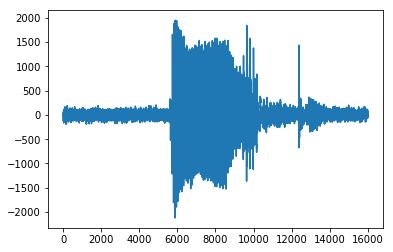

音频重建生成


In [2]:
import wave
import numpy as np
np.random.seed(1337)  # for reproducibility
import math
import keras
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
import tensorflow as tf

filename = './speech/bed/00f0204f_nohash_0.wav'
def read_wav_data(filename):
    '''
        读取一个wav文件，返回声音信号的时域谱矩阵和播放时间
    '''
    wav = wave.open(filename,"rb") # 打开一个wav格式的声音文件流
    num_frame = wav.getnframes() # 获取帧数
    print('帧数：',num_frame)
    num_channel=wav.getnchannels() # 获取声道数
    print('声道数：',num_channel)
    framerate=wav.getframerate() # 获取帧速率
    print('帧速率：',framerate)
    num_sample_width=wav.getsampwidth() # 获取实例的比特宽度，即每一帧的字节数
    print('实例的比特宽度，即每一帧的字节数',num_sample_width)
    str_data = wav.readframes(num_frame) # 读取全部的帧
    wav.close() # 关闭流
    wave_data = np.fromstring(str_data, dtype = np.short) # 将声音文件数据转换为数组矩阵形式
    wave_data.shape = -1, num_channel # 按照声道数将数组整形，单声道时候是一列数组，双声道时候是两列的矩阵
    wave_data = wave_data.T # 将矩阵转置
    return wave_data, framerate, num_frame, num_channel, num_sample_width, str_data
def wav_show(wave_data, fs): # 显示出来声音波形
    time = np.arange(0, len(wave_data)) * (1.0/fs)  # 计算声音的播放时间，单位为秒
    # 画声音波形
    plt.plot(time, wave_data) 
    plt.title('Original wave')
    plt.show()  
def minmax_norm(x):
    x = (x-min(x))/(max(x)-min(x))
    print(x)
    return x
#生成重建的wav
def Generate_Wav(filename, wave_data, framerate, num_frame, num_channel, num_sample_width):
    
    wave_data = wave_data.astype(np.short)
    #open a wav document
    f = wave.open(filename,"wb")
    #set wav params
    f.setnchannels(num_channel)
    f.setsampwidth(num_sample_width)
    f.setframerate(framerate)
    f.setnframes(num_frame)
    #turn the data to string
    f.writeframes(wave_data.tostring())
    f.close()

    
wave_data, fs, num_frame, num_channel, num_sample_width, str_data = read_wav_data(filename)  
wav_show(wave_data[0],fs)
wave_data=wave_data[0]
    
# data pre-processing
# x_train = wave_data.astype('float32') + max(wave_data)   # minmax_normalized
xmax = max(wave_data)
xmin = min(wave_data)
x_train = minmax_norm(wave_data)
x_train = x_train.reshape((1,16000))
#print((x_train))

x_train_noisy = x_train + np.random.normal(loc = 0, scale = 1., size = x_train.shape)
# x_train_noisy = np.clip(x_train_noisy, 0., 1.)
input_wave = Input(shape = (16000,))
encode1 = Dense(1600, activation = 'relu')(input_wave)
encoded = Dense(160, activation = 'relu')(encode1)
decode1 = Dense(1600, activation = 'sigmoid')(encoded)
decoded = Dense(16000, activation = 'sigmoid')(decode1)

autoencoder = Model(input = input_wave, output = decoded)

autoencoder.compile(optimizer = 'adam', loss = 'mse')
autoencoder.summary()

autoencoder.fit(x_train_noisy, x_train, epochs = 20)
print('**************************最终结果****************************************')
decoded = autoencoder.predict(x_train_noisy)[0]
print(type(decoded))
decoded = decoded*(xmax-xmin)+xmin # denormalized
mse = np.mean(pow(abs(wave_data-decoded),2))
print('mse: ',mse)
print(decoded)
plt.plot(decoded)
plt.show()
plt.title('Reconstructed wave')
filename = './reconstruct_bed.wav'
Generate_Wav(filename, decoded, fs, num_frame, num_channel, num_sample_width )
print('音频重建生成')